In [1]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply
from keras.models import Model
from keras.layers import Concatenate
from keras.layers.core import *
from keras.layers import LSTM
from keras.models import *
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn import metrics
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
#from keras.models import Sequential
from numpy.random import seed
from utils import *
from model import *

F:\Applications\Anaconda\envs\attn_based_LSTM_env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ARIMA.py

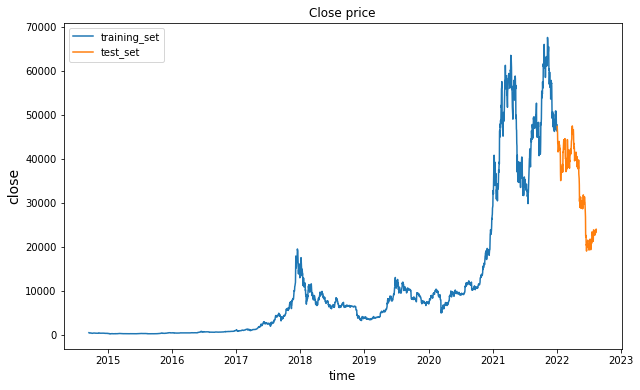

In [2]:
data = pd.read_csv('F:\ML_Bootcamp\capstone_project\BTC-USD.csv')
data.index = pd.to_datetime(data['Date']) 
data.drop(['Date'], axis=1, inplace=True)
test_set2 = data.loc['2022-01-02':, :] 
data = pd.DataFrame(data, dtype=np.float64)

training_set = data.loc[:'2022-01-01', :]
test_set = data.loc['2022-01-02':, :]

plt.figure(figsize=(10, 6))
plt.plot(training_set['Close'], label='training_set')
plt.plot(test_set['Close'], label='test_set')
plt.title('Close price')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [3]:
train_series = training_set["Close"]
test_series = test_set["Close"]
adf_test(train_series)

                                value
Test Statistic Value         -0.82238
p-value                      0.812459
Lags Used                          28
Number of Observations Used      2635
Critical Value(1%)          -3.432834
Critical Value(5%)          -2.862638
Critical Value(10%)         -2.567354


In [4]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
adf_test(train_diff)

                                value
Test Statistic Value        -8.444807
p-value                           0.0
Lags Used                          28
Number of Observations Used      2634
Critical Value(1%)          -3.432835
Critical Value(5%)          -2.862638
Critical Value(10%)         -2.567354


In [5]:
# order=(p,d,q)
#model = sm.tsa.ARIMA(endog=train_diff, order=(7, 1, 0)).fit()
#print(model.summary())

history = [x for x in train_diff]
# print('history', type(history), history)
predictions = list()
# print('test_set.shape', test_set.shape[0])
for t in range(test_diff.shape[0]):
    model1 = sm.tsa.ARIMA(history, order=(2, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = np.float(yhat[0])
    predictions.append(yhat)
    obs = test_diff[t]
    # obs = np.float(obs)
    # print('obs', type(obs))
    history.append(obs)
    # print(test_set.index[t])
    # print(t+1, 'predicted=%f, expected=%f' % (yhat, obs))
#print('predictions', predictions)

F:\Applications\Anaconda\envs\attn_based_LSTM_env\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
F:\Applications\Anaconda\envs\attn_based_LSTM_env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


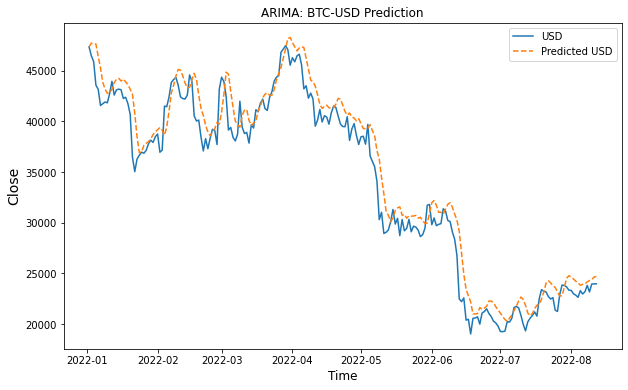

MSE: 3875143.85556
RMSE: 1968.53851
MAE: 1534.78602
R2: 0.95038


In [6]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()

reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_set.index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_set.index
#reverse_predictions_series.to_csv('./ARIMA.csv')
plt.figure(figsize=(10, 6))
plt.plot(reverse_test_diff_series, label='USD')
plt.plot(reverse_predictions_series,linestyle = "--", label='Predicted USD')
plt.title('ARIMA: BTC-USD Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

evaluation_metric(reverse_test_diff,reverse_predictions)

F:\Applications\Anaconda\envs\attn_based_LSTM_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
F:\Applications\Anaconda\envs\attn_based_LSTM_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


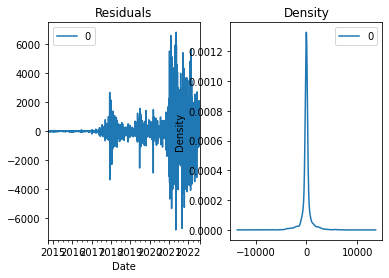

In [7]:
data_diff = data['Close'].diff()
data_diff = data_diff.dropna(inplace=False)
model2 = sm.tsa.ARIMA(endog=data_diff, order=(2, 1, 0)).fit()
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
#residuals.to_csv('./ARIMA_residuals1.csv')


XGBoost.py

In [8]:
#residuals.index = pd.to_datetime(residuals.index)
#data = pd.read_csv('./BTC-USD.csv')
#data['trade_date'] = data.index
#data = data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]
# data = pd.DataFrame(data, dtype=np.float64)
#close = data.pop('Close')
#data.insert(5, 'Close', Close)
data1 = test_set2['Close']
#residuals = pd.read_csv('./ARIMA_residuals1.csv')
#residuals.index = pd.to_datetime(residuals['trade_date'])
#residuals.pop('trade_date')
merge_data = pd.merge(data, residuals, left_index=True,right_index=True)
#merge_data = merge_data.drop(labels='2007-01-04', axis=0)
time = data[data.index >= '2022-01-02'].index

In [9]:
#Lt = pd.read_csv('./ARIMA.csv')
#Lt = Lt.drop('trade_date', axis=1)
Lt = reverse_predictions_series
Lt = np.array(Lt)
Lt = Lt.flatten().tolist()

In [10]:
merge_data.drop(['Adj Close'], axis=1,inplace=True)

In [11]:
train, test = prepare_data(merge_data, n_test=223, n_in=6, n_out=1)

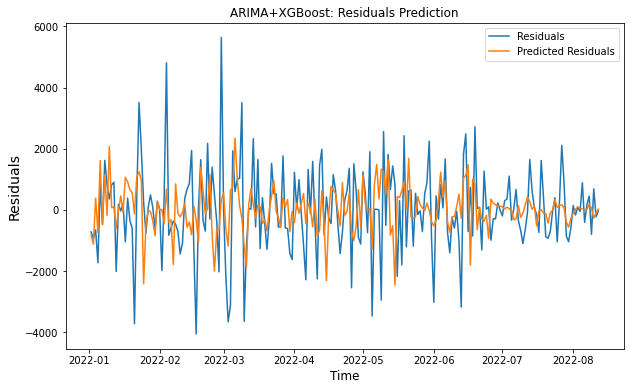

In [12]:
y, yhat = walk_forward_validation(train, test)
plt.figure(figsize=(10, 6))
plt.plot(time, y, label='Residuals')
plt.plot(time, yhat, label='Predicted Residuals')
plt.title('ARIMA+XGBoost: Residuals Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Residuals', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

MSE: 4855706.03723
RMSE: 2203.56666
MAE: 1689.74536
R2: 0.93782


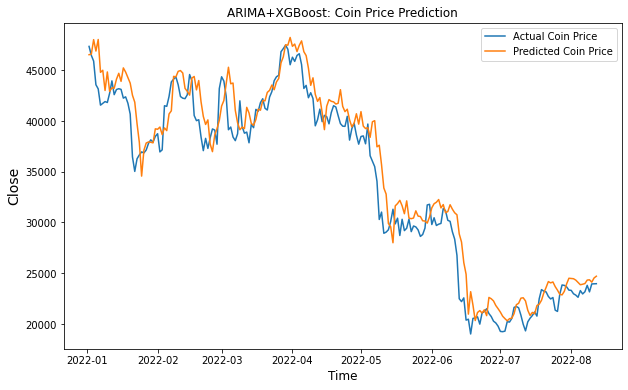

In [13]:
finalpredicted_price = [i + j for i, j in zip(Lt, yhat)]
evaluation_metric(data1, finalpredicted_price)
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Actual Coin Price')
plt.plot(time, finalpredicted_price, label='Predicted Coin Price')
plt.title('ARIMA+XGBoost: Coin Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

LSTM.py

In [14]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]], "GPU")

seed(1)
tf.random.set_seed(1)

n_timestamp = 10
n_epochs = 50
# ====================================
#      model type：
#            1. single-layer LSTM
#            2. multi-layer LSTM
#            3. bidirectional LSTM
# ====================================
model_type = 3

In [15]:
#yuan_data = pd.read_csv('./BTC-USD.csv')  
#yuan_data.index = pd.to_datetime(yuan_data['trade_date'], format='%Y%m%d') 
#yuan_data = yuan_data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]

#data = pd.read_csv('./ARIMA_residuals1.csv')
#data.index = pd.to_datetime(data['trade_date'])
#data = data.drop('trade_date', axis=1)
# data = pd.merge(data, yuan_data, on='trade_date') 
yuan_data = data
data = residuals

In [16]:
yuan_data = yuan_data.drop(['Adj Close'], axis=1)

In [17]:
#Lt = pd.read_csv('./ARIMA.csv')
Lt = pd.DataFrame(reverse_predictions_series)
Lt['Close'] = Lt.iloc[:,0]
idx = 2664
training_set = data.iloc[1:idx, :]
test_set = data.iloc[idx:, :]
yuan_training_set = yuan_data.iloc[1:idx, :]
yuan_test_set = yuan_data.iloc[idx:, :]

In [18]:
sc = MinMaxScaler(feature_range=(0, 1))
yuan_sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(test_set)
yuan_training_set_scaled = yuan_sc.fit_transform(yuan_training_set)
yuan_testing_set_scaled = yuan_sc.fit_transform(yuan_test_set)

In [19]:
X_train, y_train = data_split(training_set_scaled, n_timestamp)
yuan_X_train, yuan_y_train = data_split(yuan_training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
yuan_X_train = yuan_X_train.reshape(yuan_X_train.shape[0], yuan_X_train.shape[1], 5)

In [20]:
X_test, y_test = data_split(testing_set_scaled, n_timestamp)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
yuan_X_test, yuan_y_test = data_split(yuan_testing_set_scaled, n_timestamp)
yuna_X_test = yuan_X_test.reshape(yuan_X_test.shape[0], yuan_X_test.shape[1], 5)

In [21]:
model, yuan_model = lstm(model_type,X_train,yuan_X_train)
print(model.summary())
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam,
              loss='mse')
yuan_model.compile(optimizer=adam,
                   loss='mse')

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)
yuan_history = yuan_model.fit(yuan_X_train, yuan_y_train,
                              batch_size=32,
                              epochs=n_epochs,
                              validation_data=(yuan_X_test, yuan_y_test),
                              validation_freq=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              20800     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

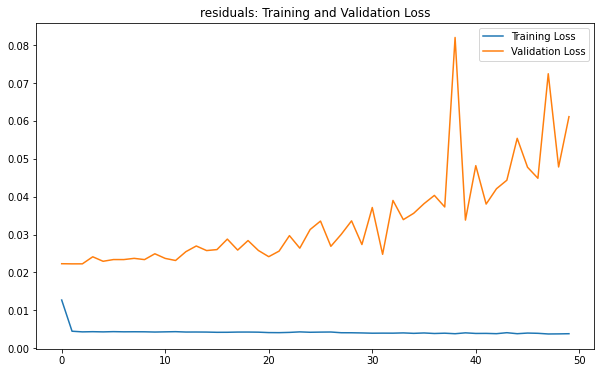

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('residuals: Training and Validation Loss')
plt.legend()
plt.show()

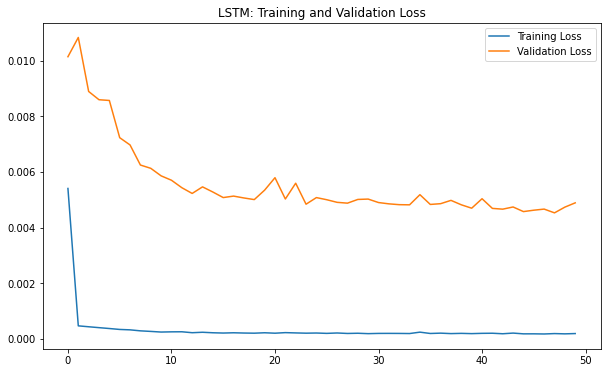

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(yuan_history.history['loss'], label='Training Loss')
plt.plot(yuan_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

In [24]:
yuan_predicted_stock_price = yuan_model.predict(yuan_X_test)
yuan_predicted_stock_price = yuan_sc.inverse_transform(yuan_predicted_stock_price)
yuan_predicted_stock_price_list = np.array(yuan_predicted_stock_price[:, 3]).flatten().tolist()
yuan_predicted_stock_price1 = {
    'Date': yuan_data.index[idx+10:],
    'Close': yuan_predicted_stock_price_list
}
yuan_predicted_stock_price1 = pd.DataFrame(yuan_predicted_stock_price1)
yuan_predicted_stock_price1 = yuan_predicted_stock_price1.set_index(['Date'], drop=True)
yuan_real_stock_price = yuan_sc.inverse_transform(yuan_y_test)
yuan_real_stock_price_list = np.array(yuan_real_stock_price[:, 3]).flatten().tolist()
yuan_real_stock_price1 = {
    'Date': yuan_data.index[idx+10:],
    'Close': yuan_real_stock_price_list
}
yuan_real_stock_price1 = pd.DataFrame(yuan_real_stock_price1)
yuan_real_stock_price1 = yuan_real_stock_price1.set_index(['Date'], drop=True)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price_list = np.array(predicted_stock_price[:, 0]).flatten().tolist()

predicted_stock_price1 = {
    'Date': data.index[idx+10:],
    'Close': predicted_stock_price_list
}
predicted_stock_price1 = pd.DataFrame(predicted_stock_price1)

predicted_stock_price1 = predicted_stock_price1.set_index(['Date'], drop=True)

real_stock_price = sc.inverse_transform(y_test)
finalpredicted_stock_price = pd.concat([Lt, predicted_stock_price1]).groupby('Date')['Close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['Date']) # 将时间格式改变一下
finalpredicted_stock_price = finalpredicted_stock_price.drop(['Date'], axis=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - 0s 2ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report th

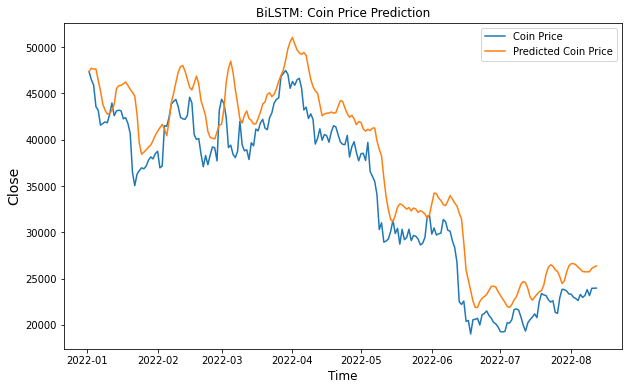

In [25]:
plt.figure(figsize=(10, 6))
# print('yuan_real', yuan_real_stock_price1)
plt.plot(yuan_data.loc['2022-01-02':, 'Close'], label='Coin Price')
plt.plot(finalpredicted_stock_price['Close'], label='Predicted Coin Price')
plt.title('BiLSTM: Coin Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [26]:
yhat = yuan_data.loc['2022-01-02':, 'Close']
evaluation_metric(finalpredicted_stock_price['Close'],yhat)

MSE: 13926175.18015
RMSE: 3731.77909
MAE: 3184.37691
R2: 0.82323


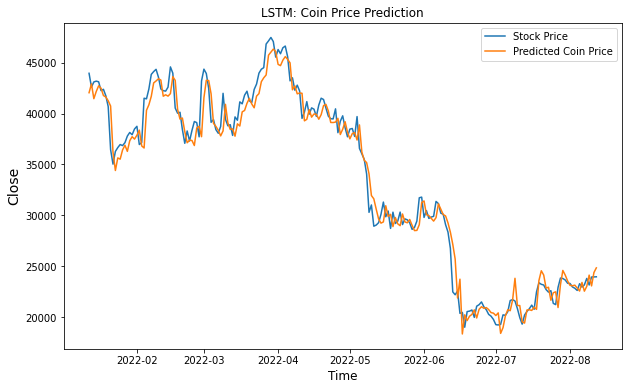

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(yuan_real_stock_price1['Close'], label='Stock Price')
plt.plot(yuan_predicted_stock_price1['Close'], label='Predicted Coin Price')
plt.title('LSTM: Coin Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [28]:
yhat = yuan_real_stock_price1['Close']
evaluation_metric(yuan_predicted_stock_price1['Close'],yhat)

MSE: 1890424.27426
RMSE: 1374.92701
MAE: 1027.55605
R2: 0.97336


Main.py

In [29]:
data_yuan = yuan_data
data1= merge_data

In [30]:
#data1 = pd.read_csv("./BTC-USD.csv")
#data1.index = pd.to_datetime(data1['trade_date'], format='%Y%m%d')
#data1 = data1.drop(['ts_code', 'trade_date', 'turnover_rate', 'volume_ratio', 'pb', 'total_share', 'float_share', 'free_share'], axis=1)
#data1 = data1.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]
#data_yuan = data1
#residuals = pd.read_csv('./ARIMA_residuals1.csv')
#residuals.index = pd.to_datetime(residuals['trade_date'])
#residuals.pop('trade_date')
#data1 = pd.merge(data1, residuals, on='trade_date')
data = data1.iloc[:2662, :] 
data2 = data1.iloc[2662:, :] 

In [31]:
len(data)

2662

In [32]:
len(data2)

223

In [33]:
TIME_STEPS = 20

data, normalize = NormalizeMult(data)
print('#', normalize)
pollution_data = data[:, 3].reshape(len(data), 1)

train_X, _ = create_dataset(data, TIME_STEPS)
_, train_Y = create_dataset(pollution_data, TIME_STEPS)

print(train_X.shape, train_Y.shape)

(6, 2)
# [[ 1.76897003e+02  6.75497344e+04]
 [ 2.11731003e+02  6.87896250e+04]
 [ 1.71509995e+02  6.63820625e+04]
 [ 1.78102997e+02  6.75668281e+04]
 [ 5.91457000e+06  3.50967941e+11]
 [-6.79390549e+03  6.82132485e+03]]
(2641, 20, 6) (2641, 1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 64)       448         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 20, 128)     66048       ['dropout[0][0]']                
 )                                                                                            

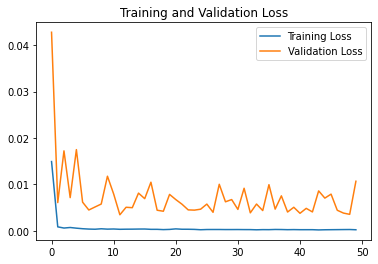

In [34]:
m = attention_model(INPUT_DIMS=6)
m.summary() 
adam = Adam(learning_rate=0.01)
m.compile(optimizer=adam, loss='mse') 
history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_split=0.1)
m.save("./BTC_model.h5")
np.save("BTC_normalize.npy", normalize)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Index(['Open', 'High', 'Low', 'Close', 'Volume', 0], dtype='object')
(6, 2)
testX Y shape is: (202, 20, 6) (202, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 6)]      0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 20, 64)       448         ['input_3[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 20, 64)       0           ['conv1d_2[0][0]']               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 20, 128)     66048       ['dropout_

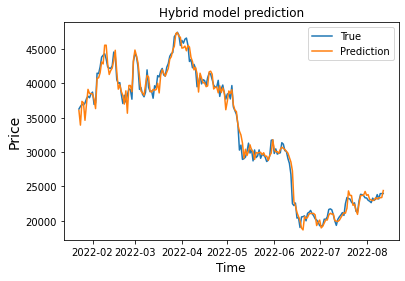

In [37]:
class Config:
    def __init__(self):
        self.dimname = 'Close'

config = Config()
name = config.dimname
# normalize = np.load("normalize.npy")
y_hat, y_test = PredictWithData(data2, data_yuan, name, 'BTC_model.h5',6)
y_hat = np.array(y_hat, dtype='float64')
y_test = np.array(y_test, dtype='float64')
evaluation_metric(y_test,y_hat)
time = pd.Series(data1.index[2683:])
plt.plot(time, y_test, label='True')
plt.plot(time, y_hat, label='Prediction')
plt.title('Hybrid model prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Price', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()